# Project Report

## Navigating Germany's Rental Landscape for International Students

### Summary

<p> The project aims to analyze data concerning international students and rental properties in bayren, Germany. By examining this information, the project seeks to provide valuable insights to newcomers, helping them identify cities in bayren, Germany with the most favorable accommodation options and thus facilitating their transition to the country.</p>

### Project Flow

1. Data Acquisition:
- Obtain information about rental property listings from Immoscout24 from the provided metadata URL and download the corresponding csv file.
- Obtain the Foreign students dataset from the provided metadata URL and download the corresponding xlsx file.

Datasource1: Foreign students in Germany
- Metadata URL: https://data.europa.eu/data/datasets/https-www-datenportal-bmbf-de-portal-2-5-34
- Data URL: https://www.datenportal.bmbf.de/portal/Tabelle-2.5.34.xls
- Data Type: xlsx

This dataset comprises information about international students admitted to degree programs in  bayren Germany over a specific time period. It includes data on the students' nationalities, degree programs, admission dates, and other relevant attributes.

Datasource2: Immoscout24 dataset
- Metadata URL: https://www.kaggle.com/datasets/corrieaar/apartment-rental-offers-in-germany
- Data URL: https://www.kaggle.com/datasets/corrieaar/apartment-rental-offers-in-germany/download?datasetVersionNumber=6
- Data Type: xlsx

This dataset comprises information about rental property listings from Immoscout24, which is the largest real estate platform in bayren Germany. It includes details about rental prices, property characteristics, and the property's location.

### Used Libraries

Import all necessary Libraries

In [107]:
# Import all necessary libraries
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import folium
import matplotlib.pyplot as plt
from IPython.display import display

### Data Extraction

Immoscout dataset was sourced from Kaggle, by enabling Kaggle API, from kaggle "API" section and click on "Create New API Token". This will download a file named kaggle.json to your computer then Store Kaggle API Key in your system and the second dataset of Forigen students in Bavaria Germany was sourced from europa.eu.

```python
#Data Extraction
def fetch_kaggle_dataset(dataset, target_folder, filename):
    api = KaggleApi()
    api.authenticate()
    api.authenticate()
    username, dataset_name = dataset.split('/')[-2:]
    zip_file_path = os.path.join(target_folder,f"{dataset_name}.zip")
    api.dataset_download_files(f"{username}/{dataset_name}", path=target_folder, unzip=False)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extract(filename, path=target_folder)

def data_extraction_csv(path):
    t1 = time()
    print("Data Extraction in progress...")

    try:
        df = pd.read_csv(path, encoding='latin-1')
    except Exception as e:
        print("Error occurred during file reading:", str(e))
        return None
    t2 = time()
    print("Finish: Data Extraction {} s ".format(t2 - t1))
    return df

    def data_extraction_xls(path):
    t1 = time()
    print("Data Extraction in progress...")

    try:
        df = pd.read_excel(path, engine='openpyxl')
    except Exception as e:
        print("Error occurred during file reading:", str(e))
        return None
    t2 = time()
    print("Finish: Data Extraction {} s ".format(t2 - t1))
    return df
```

### Data Cleaning and Preprocessing:
1. Load and explore the Immoscout24 and Forigen Students in Germany dataset.
2. Clean the datasets by removing irrelevant columns and handling missing values.
3. Perform any necessary data transformations or feature engineering.

Data Transformation
```python
    # Check if column is empty and drop corresponding rows
    df1.dropna(subset=['regio1', 'regio2', 'noRooms'], inplace=True)
    
    # Fetch only Bayren state dataset
    df1 = df1[df1['regio1'] == 'Bayern']
        
    # correct the formats of data values
    df1['regio2'] = df1['regio2'].str.encode('latin-1').str.decode('utf-8')
  
    # only fetch data with city name available in students data
    university_cities = df2['City'].unique()
    df1 = df1[df1['regio2'].isin(university_cities)]

    # Format dataset
    df1 = data_transformation(df1, df1_rename_cols, df1_drop_cols)
    data_loader("../dataset.sqlite", df1, "immoscout")

     # correct date format in year cloumn
    df2['Jahr'] = pd.to_datetime(df2['Jahr'].str.split('/').str[0], format='%Y')
    df2['Jahr'] = df2['Jahr'].dt.strftime('%Y')

    #drop rows with num values
    df2 = df2.dropna()

    # List of columns to convert from float64 to int
    columns = ['Geisteswissenschaften', 'Sozialwissenschaften', 'Mathematik',
                 'Ingenieurwissenschaften', 'Informatik',
                 'medizin', 'Landwirtschaft']
    
    # Convert selected columns to int
    df2[columns] = df2[columns].astype(int) 
```
Rename Columns
```python
    df1_rename_cols = {
        "regio1": "federalState",
        "geo_plz": "zipCode",
        "regio2": "City",
        "regio3": "Town"
    }

    df2_rename_cols = {
            "Jahr": "Year",
            "Stadt": "City",
            "Universität": "University",
            "Geisteswissenschaften": "Humanities",
            "Sozialwissenschaften": "Social sciences",
            "Mathematik": "Mathematics",
            "Ingenieurwissenschaften": "Engineering sciences",
            "Informatik": "Computer Science",
            "medizin": "Medicine",
            "Landwirtschaft": "Agriculture"
        }
```
Drop Columns
```python
    df1_drop_cols = ["picturecount", "scoutId", "geo_bln", "geo_krs", "telekomHybridUploadSpeed", "telekomTvOffer", "newlyConst", "balcony", "picturecount", "pricetrend", "telekomUploadSpeed", "scoutId", "firingTypes", "yearConstructedRange", "interiorQual", "petsAllowed", "streetPlain", "lift", "baseRentRange", "typeOfFlat", "energyEfficiencyClass", "lastRefurbish", "electricityBasePrice", "electricityKwhPrice", "date"]
```

### Extract Latitude and Longitude for Immoscout24 Dataset
```python
# Query the database and load all data into a DataFrame
immoscout_table = "SELECT * FROM immoscout"
immoscout_table = pd.read_sql_query(immoscout_table, conn)

# Create a geocoder instance
geolocator = Nominatim(user_agent="my_app")

# Initialize lists to store latitude and longitude values
latitudes = []
longitudes = []

# Iterate over each row in the DataFrame
for index, row in immoscout_table.iterrows():
    # Check if the city is Munich or Nuremberg
    if row['City'] in ['München', 'Nürnberg']:
        address = f"{row['houseNumber']} {row['street']}, {row['Town']}, {row['City']}, {row['zipCode']} , {row['federalState']}"
        try:
            location = geolocator.geocode(address, timeout=10)
            if location is not None:
                latitudes.append(location.latitude)
                longitudes.append(location.longitude)
                print(address, ":", location.latitude, location.longitude)
            else:
                latitudes.append(None)
                longitudes.append(None)
        except GeocoderTimedOut:
            print(f"Geocoding timed out for address: {address}")
    else:
        # For other cities, use the existing latitude and longitude values
        latitudes.append(None)
        longitudes.append(None)

# Add latitude and longitude columns to the DataFrame
immoscout_table['latitude'] = latitudes
immoscout_table['longitude'] = longitudes

# Save the updated DataFrame back to the database
immoscout_table.to_sql('immoscout', conn, if_exists='replace', index=False)
```

### Database Structure

1. Immoscout24 Database:

In [108]:
# Connect to the database
conn = sqlite3.connect('../dataset.sqlite')  

# Query the database and load data into a DataFrames
immoscout_table = f"SELECT * FROM immoscout"
immoscout_df = pd.read_sql_query(immoscout_table, conn)
immoscout_df.head()

federalState  serviceCharge      heatingType  totalRent  yearConstructed   
0       Bayern          180.0  central_heating     2030.0           1871.0  \
1       Bayern            0.0                0     2400.0           1956.0   
2       Bayern          170.0    floor_heating      970.0           1974.0   
3       Bayern            0.0                0     2780.0           2016.0   
4       Bayern          200.0      gas_heating        0.0              0.0   

   noParkSpaces  hasKitchen  cellar  baseRent houseNumber  ...  noRoomsRange   
0           0.0           1       1    1850.0           0  ...             2  \
1           1.0           0       0    2400.0           3  ...             3   
2           1.0           1       1     800.0           0  ...             2   
3           0.0           0       0    2780.0          51  ...             3   
4           0.0           1       0     900.0           0  ...             4   

  garden livingSpaceRange      City            Town   
0      0                4   München        Altstadt  \
1      0                3   München  Schwabing_West   
2      0                5    Passau  Haidenhof_SÃ¼d   
3      0                4   München   Milbertshofen   
4      0                4  Würzburg        Lengfeld   

                                         description   
0  Die Wohnung (OHNE Balkon !!) liegt im 4. OG (O...  \
1  Highlights:\n\n * alle WÃ¤nde der WohnrÃ¤ume, ...   
2  WOHNEN UND ENTSPANNEN!\nÂ \nDie Architektur be...   
3  Bitte beachten Sie: Die Wohnung ist komplett m...   
4  Helle 4,5-Zimmerwohnung in ruhigem, kleinen Wo...   

                                          facilities  heatingCosts  latitude   
0  - Eichenparkettboden im Wohn-EZ u. im Schlafzi...           0.0       NaN  \
1  Waschmaschine in der Wohnung\nFlachbildfernseh...           0.0       NaN   
2  - Gartenwohnung in bester Lage\n- 2 Zimmer + H...           0.0       NaN   
3  Waschmaschine in der Wohnung\nFlachbildfernseh...           0.0  48.18808   
4                                                  0           0.0       NaN   

   longitude  
0        NaN  
1        NaN  
2        NaN  
3   11.54337  
4        NaN  

[5 rows x 28 columns]

2. Forigen Student Dataset

In [109]:
# Connect to the database
conn = sqlite3.connect('../dataset.sqlite')  

# Query the database and load forigen students data into a DataFrames
intstudents_table = f"SELECT * FROM intstudents"
intstudents_df = pd.read_sql_query(intstudents_table, conn)
intstudents_df.head()

Region                                         University        City   
0  bayren  Ostbayerische Technische Hochschule (OTH) Rege...  Regensburg  \
1  bayren  Ostbayerische Technische Hochschule (OTH) Rege...  Regensburg   
2  bayren  Ostbayerische Technische Hochschule (OTH) Rege...  Regensburg   
3  bayren  Ostbayerische Technische Hochschule (OTH) Rege...  Regensburg   
4  bayren  Ostbayerische Technische Hochschule (OTH) Rege...  Regensburg   

   Year  Humanities  Social sciences  Mathematics  Engineering sciences   
0  1998          30               16           58                     4  \
1  1999          20               20           58                     0   
2  2000          27               18           58                     2   
3  2001          27               18           58                     4   
4  2002          42               18           58                     4   

   Computer Science  Medicine  Agriculture  
0                74        18           16  
1                36        20           20  
2                31        18           18  
3                36        18           18  
4                42        18           18

### Expolatory Data Analysis

1. Perform correlation analysis between the proximity of rental property availability in Bavaria and the number of foreign students in Bavaria, Germany.
2. Visualize the correlation using appropriate charts or plots.


### Bar Plot

A bar plot displaying the distribution of the number of students according to the cities of Bavaria.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


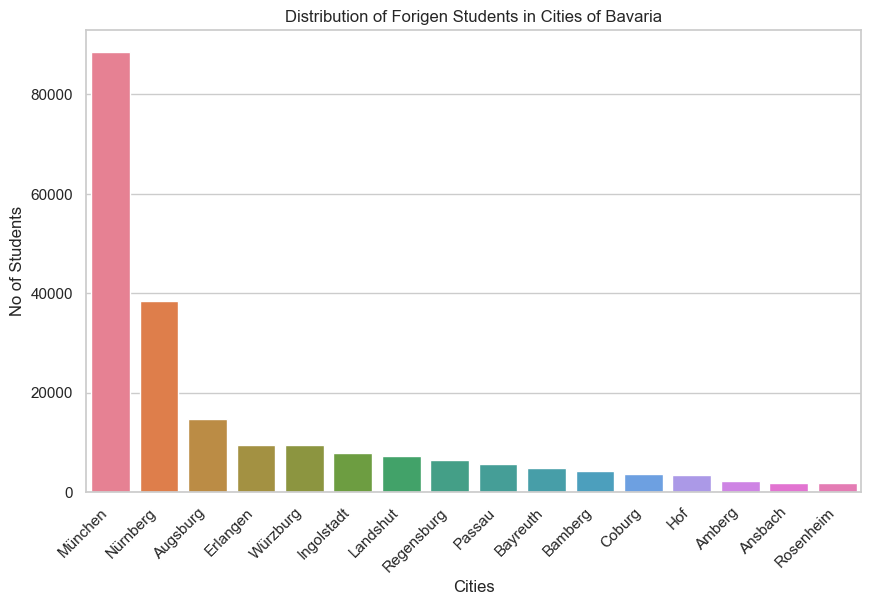

In [110]:
# List of columns to convert from float64 to int
columns = ['Humanities', 'Social sciences', 'Mathematics',
                 'Engineering sciences', 'Computer Science',
                 'Medicine', 'Agriculture']

# Calculate total students and add a new column
intstudents_df['Total-Student'] = intstudents_df[columns].sum(axis=1)

columns_to_use = ['City', 'Total-Student']
df_bar = intstudents_df[columns_to_use].groupby('City').sum()

# Sort the DataFrame by Total-Student in ascending order
df_bar = df_bar.sort_values(by='Total-Student', ascending=False)

# Set a seaborn color palette for different cities
city_palette = sns.color_palette("husl", n_colors=len(df_bar))

# Plot the compound bar graph using seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=df_bar.index, y='Total-Student', data=df_bar, palette=city_palette, hue=df_bar.index)

ax.set_xlabel('Cities')
ax.set_ylabel('No of Students')
ax.set_title('Distribution of Forigen Students in Cities of Bavaria')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Remove the legend, as it's not needed in this case
ax.legend().set_visible(False)

plt.show()



### Trendline Plot

A trendline plot displaying the trend of foreign students studying in different cities of Bavaria over the last 20 years.

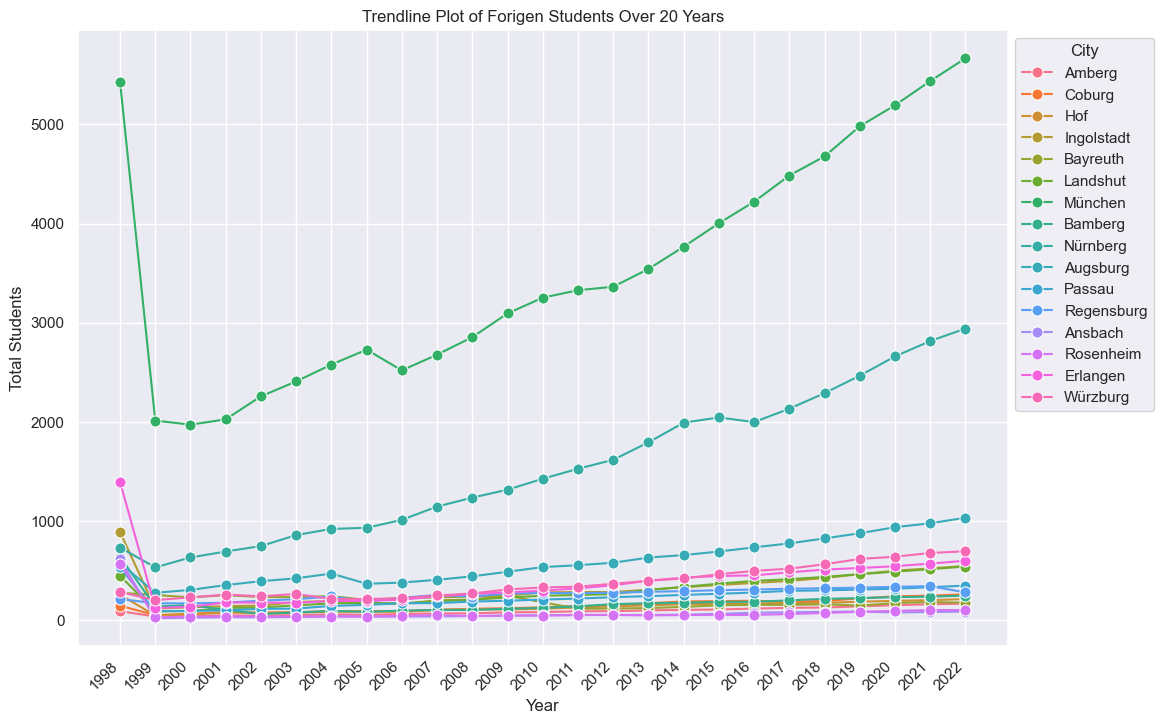

In [112]:
columns_to_use = ['City', 'Year', 'Total-Student']
df_trendline = intstudents_df[columns_to_use].copy()

# Group by 'City' and 'Year', and sum the 'Total-Student' values within each group
df_trendline_grouped = df_trendline.groupby(['City', 'Year'])['Total-Student'].sum().reset_index()

# Sort the DataFrame by 'Year'
df_trendline_grouped = df_trendline_grouped.sort_values(by='Year')

sns.set(style="darkgrid")

# Create a trendline plot
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='Year', y='Total-Student', hue='City', data=df_trendline_grouped, errorbar=None, marker='o', markersize=8)

plt.title('Trendline Plot of Forigen Students Over 20 Years')
plt.xlabel('Year')
plt.ylabel('Total Students')
plt.legend(title='City', loc='upper left', bbox_to_anchor=(1, 1))

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

plt.show()


### Pie Plot

A pie plot displaying the cities that contain a higher percentage of available apartments in different cities of Bavaria. 

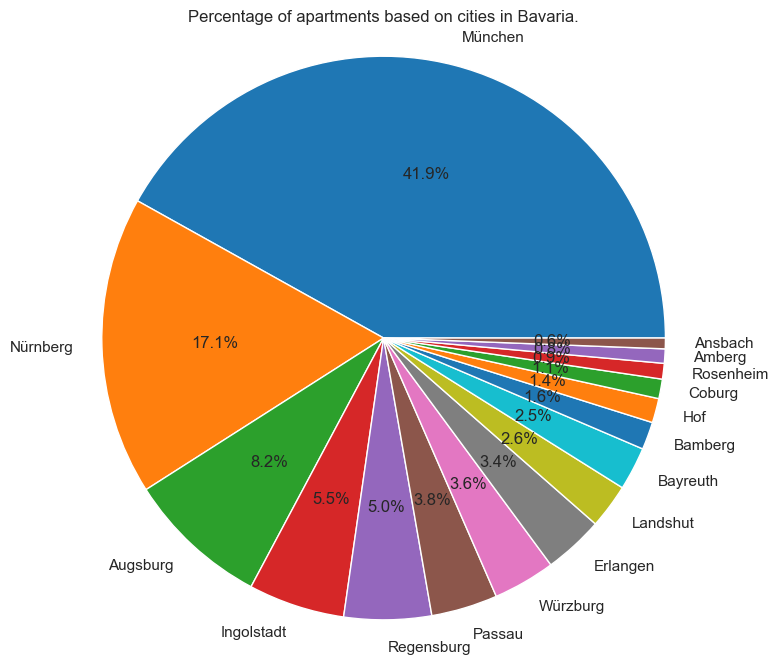

In [121]:
apartments_wrt_town = immoscout_df['City'].value_counts()

# Sort the values for better visualization
apartments_wrt_town_sorted = apartments_wrt_town.sort_values(ascending=False)

# Set a seaborn color palette for different cities
town_palette = sns.color_palette("tab10", n_colors=len(apartments_wrt_town_sorted))

# Plot the pie chart using seaborn
plt.figure(figsize=(8, 8))
plt.pie(apartments_wrt_town_sorted.values, labels=apartments_wrt_town_sorted.index, autopct='%1.1f%%', colors=town_palette)
plt.title('Percentage of apartments based on cities in Bavaria')
plt.axis('equal') 
plt.show()


### Bubble Plot

A bubble plot visualizing the locations of apartments available in Munich and Nuremberg based on longitude and latitude values calculated using the apartment addresses.

- First extracting Munich and Nurnberg apartments data from the dataset. 

In [122]:
# Extract data for Munich and Nuremberg
munich_data = immoscout_df[immoscout_df['City'] == 'München'][['latitude', 'longitude']].dropna().values.tolist()
nuremberg_data = immoscout_df[immoscout_df['City'] == 'Nürnberg'][['latitude', 'longitude']].dropna().values.tolist()

- Bubble Plot for Munich:

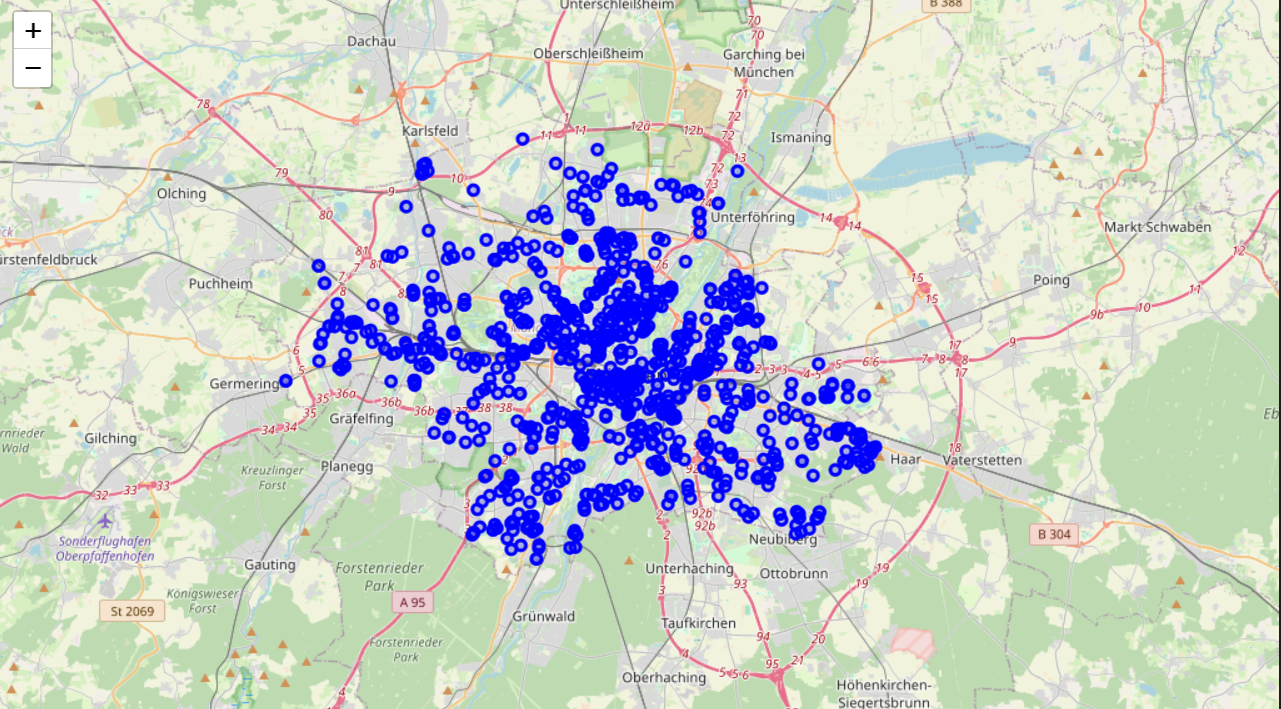

In [123]:
# Create a Folium map
map_center = [48.1351, 11.5820]  # Center the map around Munich
munich_map = folium.Map(location=map_center, zoom_start=11)

# Add Circle markers to the map
for location in munich_data:
    folium.Circle(location=location, radius=200, color='blue', fill=True).add_to(munich_map)

# Display muninch_map
image = Image.open('output/munich_map.PNG')
display(image)

- Bubble Plot for Nurnberg:

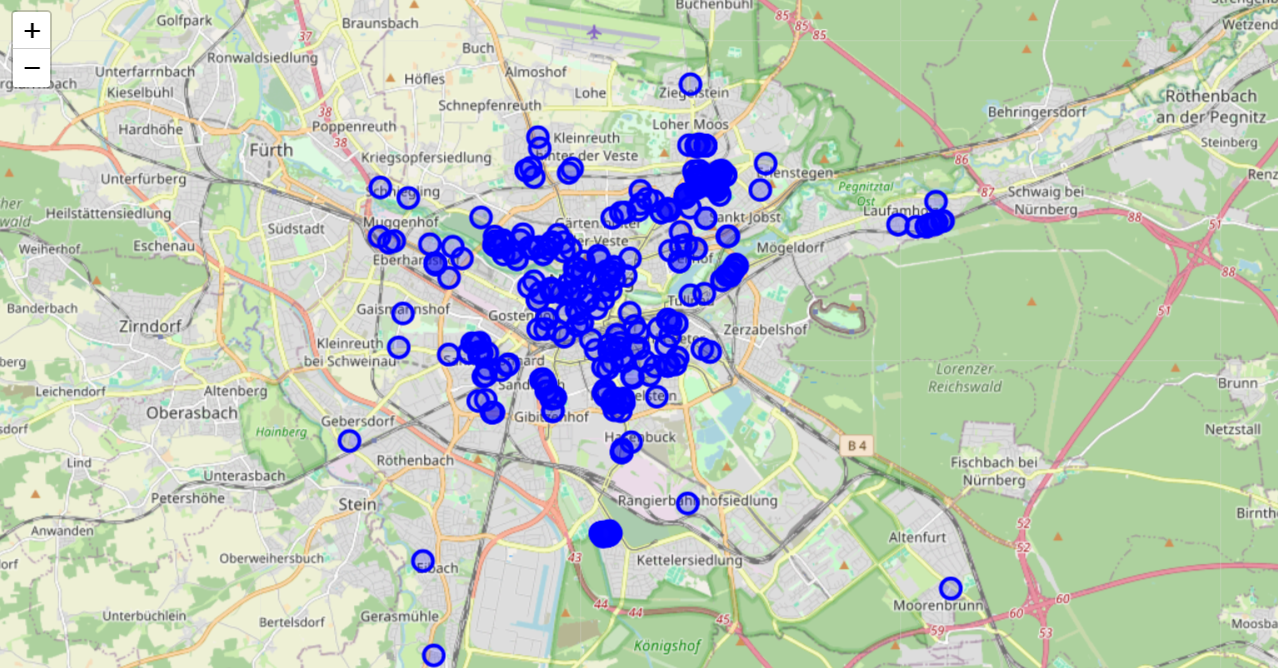

In [124]:
# Create a Folium map
map_center = [49.4521, 11.0767]  # Center the map around Munich
nurnberg_map = folium.Map(location=map_center, zoom_start=11)

# Add Circle markers to the map
for location in nuremberg_data:
    folium.Circle(location=location, radius=200, color='blue', fill=True).add_to(nurnberg_map)

# Display nurnberg_map
image = Image.open('output/nurnberg_map.PNG')
display(image)

### Comparision Analysis

### Filled-In Bar Plot
The filled bar graph illustrates the number of foreign students and available accommodations in Bavaria for the year 2022. The data is segmented by cities, providing insights into the accommodation availability for international students in different regions.

- Calculate the number of available rooms and group by cities.

In [125]:
# Filter the DataFrame to include only rows where 'noRooms' is an integer
filtered_df = immoscout_df[immoscout_df['noRooms'].astype(int) == immoscout_df['noRooms']]

# Group by Cities and calculate the total number of rooms in each city
total_rooms_per_city = filtered_df.groupby('City')['noRooms'].sum().reset_index()

- Calculate the number of students in each city in 2022.

In [126]:
columns_to_use = ['City', 'Total-Student']
# Fetch student data for year 2022
intstudents_df = intstudents_df[intstudents_df['Year'] == '2022']

#groupby data according to Cities
df_bar = intstudents_df[columns_to_use].groupby('City').sum()
df_bar.reset_index(inplace=True)
df_bar.rename(columns={'City': 'City'}, inplace=True)

- Calculate the percentage of occupied and available rooms in cities for the year 2022.

In [127]:
# Claulate percatage of number of room occupied and available in cities in 2022
df_bar['Total-Student-percentage'] = (df_bar['Total-Student']/total_rooms_per_city['noRooms'])*100

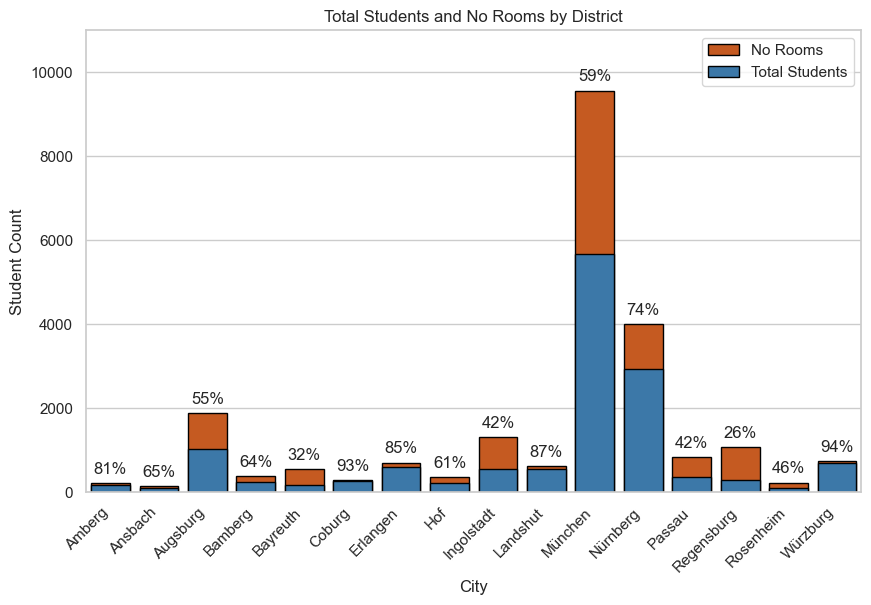

In [140]:
# Set the Seaborn style to 'whitegrid' for a light background
sns.set_style("whitegrid")

# Create a bar plot with visually attractive color scheme
plt.figure(figsize=(10, 6), facecolor='None')  

# Define visually attractive colors
total_students_color = sns.color_palette("Blues")[4] 
no_rooms_color = sns.color_palette("Oranges")[4]  

ax1 = sns.barplot(x='City', y='noRooms', data=total_rooms_per_city, color=no_rooms_color, edgecolor='black', label='No Rooms')
ax2 = sns.barplot(x='City', y='Total-Student', data=df_bar, color=total_students_color, edgecolor='black', label='Total Students')

# Annotate each bar with values from the 'annotation_column'
for p, annotation_value in zip(ax1.patches, df_bar['Total-Student-percentage']):
    ax1.annotate(f'{annotation_value:.0f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.xlabel('City')
plt.ylabel('Student Count')
plt.title('Total Students and No Rooms by District')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')
# Display the legend
plt.legend()
plt.ylim(0,11000)
# Show the plot
plt.show()


### Conclusion

Upon analyzing the data, a clear trend emerges, indicating that larger cities in Bavaria tend to have a higher percentage of filled accommodations. Specifically, Munich exhibits a 59% occupancy rate, Nuremberg follows closely with 74%, and Ingolstadt is at 42%. On the contrary, smaller cities like Erlangen show a significantly higher occupancy rate of 85%, and Coburg is at an impressive 93%.

This leads to the conclusion that students planning to come to Bavaria, especially in larger cities, have relatively more opportunities to secure accommodation. The higher percentages in Munich, Nuremberg, and Ingolstadt suggest a competitive yet available housing market for international students. However, it's noteworthy that smaller cities such as Erlangen and Coburg have a higher demand for accommodation, possibly indicating a more limited supply.

In summary, the analysis underscores the importance of considering city size and accommodation availability when planning for international studies in Bavaria. While big cities offer competitive accommodation options, students should be mindful of the housing demand in both larger and smaller cities to make informed decisions about their accommodation arrangements.